<a href="https://colab.research.google.com/github/moiren/python_tutorial/blob/master/gesture_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plan and notes:
1. need more fine-grained pupil input. try g3 first on IRF and GLM first. 
*   have requested from kanika
*   preprocess by ourselves

For g3, 
*   GLM function
*   gesture and slide changes
*   split events by gesture type

Run each individual, and split by comprehension score


****GLM 线索：https://github.com/jwdegee/2017_eLife/blob/master/defs_pupil.py

这个本人终于解释了 dependency：https://github.com/jwdegee/2017_eLife

要用这个 tools 里面 import 自己写的GLM: https://github.com/VU-Cog-Sci/analysis_tools/tree/jws_branch/Tools/other_scripts
你重点看下这个里面定义的GeneralLinearModel: functions_jw_GLM.py
以及他给了 tutorial：https://github.com/jwdegee/IPython-Notebook-Tutorials

其他人怎么用他的 code: https://github.com/search?q=functions_jw_GLM.py&type=Code

Resource list:

1. pupil preprocess in matlab and python: 
https://github.com/anne-urai/pupil_preprocessing_tutorial

how they created the IRF model and tried to convolve it with events:
https://github.com/tknapen/FIRDeconvolution/blob/master/test/pupil_preprocess_python.ipynb


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# **g3 per 0328**

In [0]:
dir = "/gdrive/My Drive/PaulLab/video_study/"

from scipy.io import loadmat
# import data
pupil_g3_per = loadmat(dir + 'g3_PER_pd_sti_clean_zs.mat')
ges_time_per = loadmat(dir + 'ges_time_per.mat')

In [0]:
import numpy as np

# define constants
sample_rate = 1000
pupil_size = pupil_g3_per['zscoredpupil'][0]
pupil_len = len(pupil_size)

pupil_time = np.arange(0,pupil_len)
pupil_time_s = np.arange(0,pupil_len/sample_rate,1/sample_rate)
print(pupil_time_s)

start_time = ges_time_per['results'][:,0]
end_time = ges_time_per['results'][:,1]
duration = ges_time_per['results'][:,2]

num = len(start_time)

[0.00000e+00 1.00000e-03 2.00000e-03 ... 2.96117e+02 2.96118e+02
 2.96119e+02]


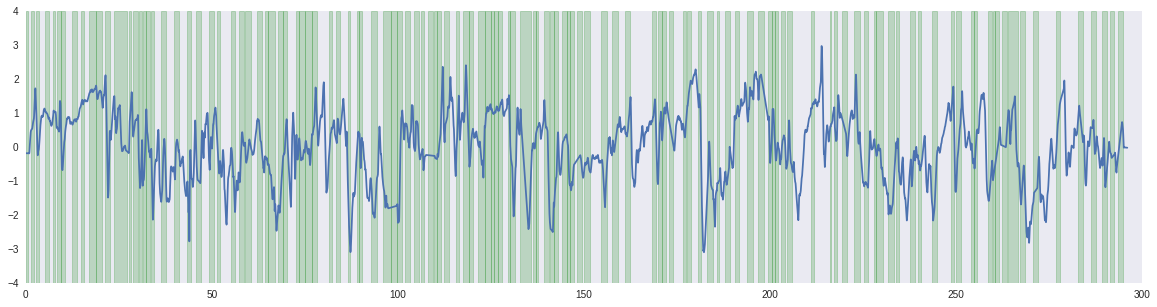

In [0]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,figsize=(20, 5))
ax.plot(pupil_time_s, pupil_size)
ax.grid(False)
plt.xlim([0,300])
plt.ylim([-4,4])
for i in range(0,num):
    rect = patches.Rectangle((start_time[i][0]/sample_rate,-4),duration[i][0]/sample_rate,8,linewidth=1,
                             edgecolor='g',facecolor='g',alpha=0.2)
    ax.add_patch(rect)
plt.show()

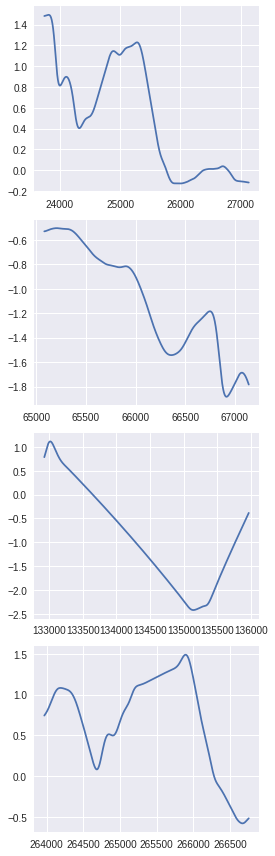

In [0]:
ind = np.where(duration > 2000)
ind = ind[0]
num_ind = len(ind)

fig,ax = plt.subplots(num_ind,1,figsize=(4, 12))
for i in range(0,num_ind):
      t = ind[i]
      s = start_time[t][0]
      e = end_time[t][0]
      x = np.arange(s,e+1)
      y = pupil_size[x]
      ax[i].plot(x, y)
#       ax[i].plot(np.arange(s,e+1), pupil_size[(int(s)-1):int(e)])
      
fig.tight_layout()
plt.show()

In [0]:
def IRF(t,t_max,w):
  h = np.power(t,w)*np.exp(-t*w/t_max)
  return h

In [0]:
t = np.arange(start_time[ind[-1]],end_time[ind[-1]]+1)
# ind_t_max = np.argmax(pupil_size[t])
# t_max = t[ind_t_max]
# w = duration[ind[-1]][0]
w = 10.1
t_max = 930

we used the canonical values of these two parameters proposed by
ref. 37, which were previously used to deconvolve pupil responses in the
attentional blink (15): w = 10.1, tmax = 930 ms.
可能要去掉下面有的1000

In [0]:
h = IRF(t/sample_rate,t_max/sample_rate,w)
plt.plot(t, np.transpose(h))

[263966 263967 263968 ... 266755 266756 266757]
(array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


# **General Linear Model**

In [0]:
import os
import numpy as np
import scipy as sp
from scipy.linalg import sqrtm, inv
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
import math

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Text(0, 0.5, 'a.u.')

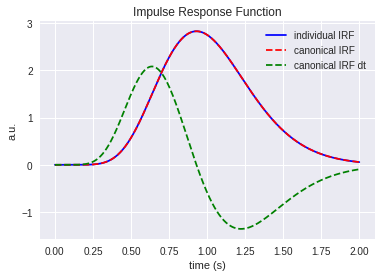

In [0]:
def pupil_IRF(timepoints, s=1.0/(10**26), n=10.1, tmax=0.93):
    
    """ pupil_IRF defines the IRF (response to a transient input) of the pupil.
    
    Parameters
    ----------
    timepoints: timepoints to evulate function
    s: scaling factor
    n: sets the width
    tmax: sets the time to peak 
    
    Returns
    -------
    y: IRF evaluated for 'timepoints'
    y_dt: IRF first derivative evaluated for 'timepoints'
    
    """
    
    # in sympy:
    t = sympy.Symbol('t')
    y = ( (s) * (t**n) * (math.e**((-n*t)/tmax)) )
    yprime = y.diff(t)
    
    # lambdify:
    y = sympy.lambdify(t, y, "numpy")
    y_dt = sympy.lambdify(t, yprime, "numpy")
    
    # evaluate:
    y = y(timepoints)
    y_dt = y_dt(timepoints)
    
    # normalize:
    y = y/np.std(y)
    y_dt = y_dt/np.std(y_dt)
    
    return (y, y_dt)


# create the IRF:
tmax_shifted = 0.93 
sample_rate = 1000
IRF_len = 2.0 # in seconds
timepoints = np.linspace(0,IRF_len,IRF_len*sample_rate)
IRF, IRF_prime = pupil_IRF(timepoints=timepoints)
IRF_shifted, IRF_prime_shifted = pupil_IRF(timepoints=timepoints, tmax=tmax_shifted)

# IRF_len = 20.0 # in seconds
# timepoints = np.linspace(0,IRF_len,IRF_len*sample_rate)
# IRF, IRF_prime = HRF(timepoints=timepoints)

# plot the IRF:
fig = plt.figure()
plt.plot(timepoints, IRF_shifted, color='b')
plt.plot(timepoints, IRF, color='r', ls='--')
plt.plot(timepoints, IRF_prime, color='g', ls='--')

plt.legend(['individual IRF', 'canonical IRF', 'canonical IRF dt',])
plt.title('Impulse Response Function')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

Text(0, 0.5, 'a.u.')

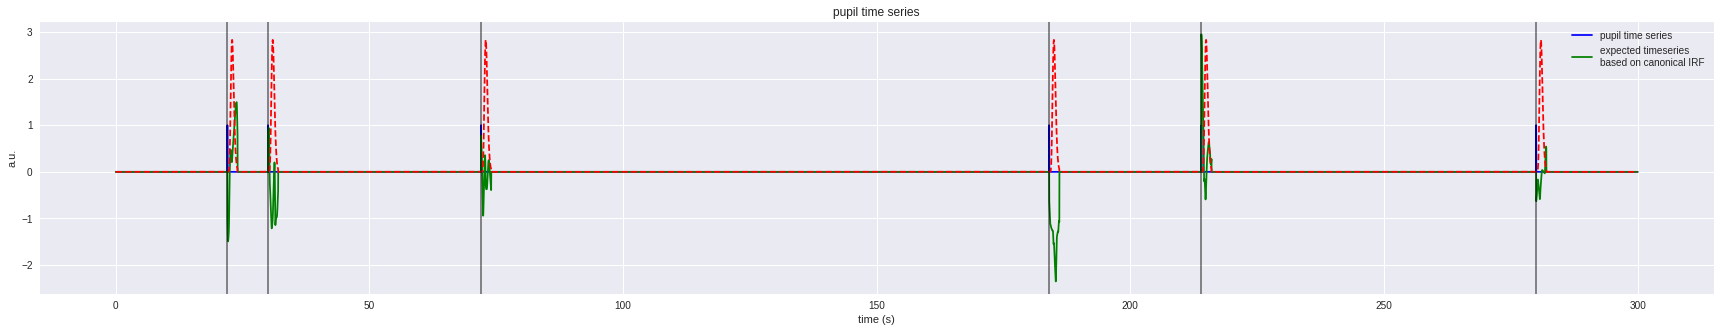

In [0]:
true_beta = 1
duration = 300 # in seconds
times = np.array([22,30,72,184,214,280]) # slide change time in perspective video, discard 296

input_signal = np.zeros(int(duration * sample_rate)) #300
for i in times: 
    input_signal[int(i*sample_rate)] = true_beta

input_signal_true = np.zeros(int(duration * sample_rate))
for i in times:
    signal_ind = np.arange(1000*i,1000*(i+2))
    input_signal_true[signal_ind] = pupil_size[signal_ind]

# convolve inputs with IRF:    
convolved_signal = (sp.convolve(input_signal, IRF, 'full'))[:-(IRF.shape[0]-1)]
# convolved_signal_shifted = (sp.convolve(input_signal, IRF_shifted, 'full'))[:-(IRF.shape[0]-1)]

# # let's add some noise:
# convolved_signal = convolved_signal + np.random.normal(0,0.2,len(convolved_signal))
# convolved_signal_shifted = convolved_signal_shifted + np.random.normal(0,0.2,len(convolved_signal_shifted))
    
# plot simulated convolved signal with noise:
timepoints = np.linspace(0,duration,duration*sample_rate)
fig = plt.figure(figsize=(30, 5))
# plt.plot(timepoints, convolved_signal_shifted, 'b')
plt.plot(timepoints, input_signal, 'b') 
plt.plot(timepoints, input_signal_true, 'g')
plt.plot(timepoints, convolved_signal, 'r', ls='--')
# plt.ylim(-1,8)
plt.legend(['pupil time series', 'expected timeseries\nbased on canonical IRF',], loc=1)
for i in times:
    plt.axvline(i, color='k', alpha=0.5)
plt.title('pupil time series')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

Text(0, 0.5, 'a.u.')

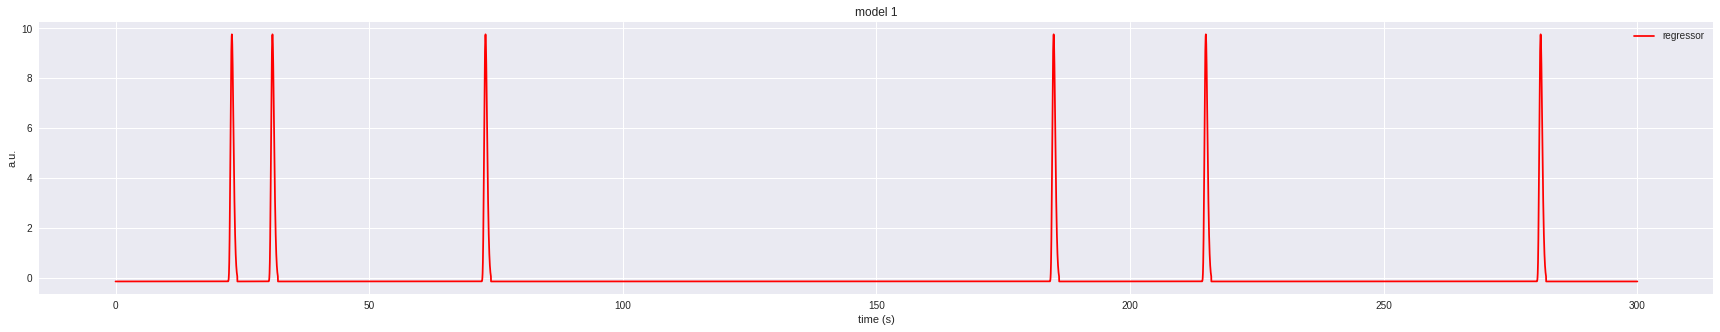

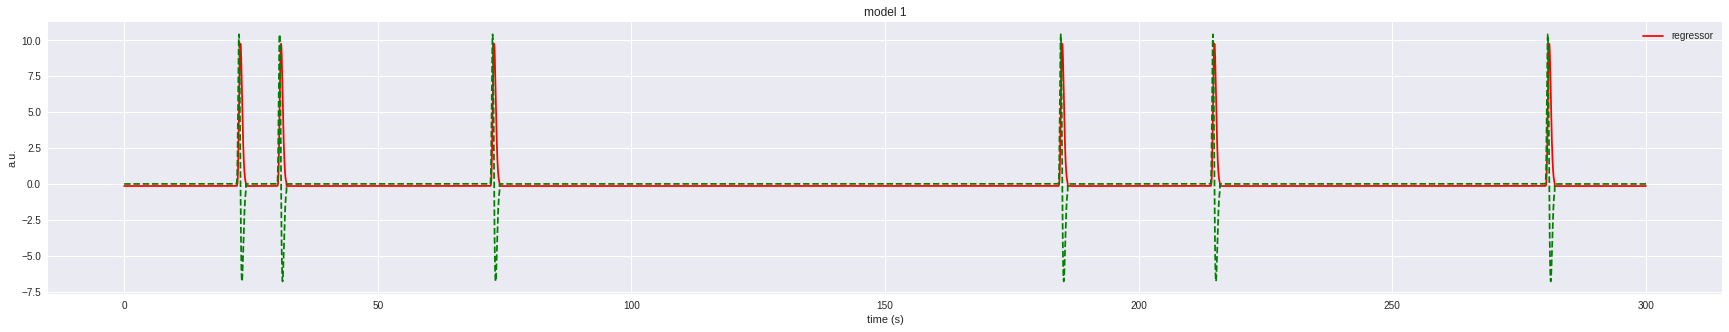

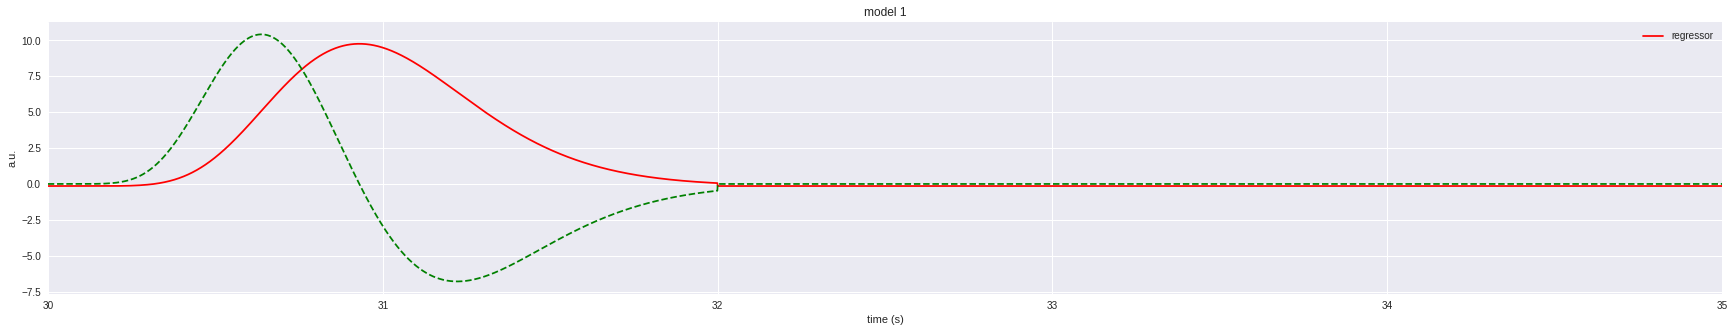

In [0]:
input_signal = np.zeros(int(duration * sample_rate))
for i in times:
    input_signal[int(i*sample_rate)] = 1

# convolve inputs with IRF:    
regr_convolved = (sp.convolve(input_signal, IRF, 'full'))[:-(IRF.shape[0]-1)]
regr_convolved_dt = (sp.convolve(input_signal, IRF_prime, 'full'))[:-(IRF_prime.shape[0]-1)]

# z-score measured data and regressors:
regr_convolved = (regr_convolved - regr_convolved.mean()) / regr_convolved.std()
regr_convolved_dt = (regr_convolved_dt - regr_convolved_dt.mean()) / regr_convolved_dt.std()
# convolved_signal_shifted = (convolved_signal_shifted - convolved_signal_shifted.mean()) / convolved_signal_shifted.std()

fig = plt.figure(figsize=(30, 5))
plt.plot(timepoints, regr_convolved, 'r',)
# plt.ylim(-4,6)
plt.legend(['regressor'], loc=1)
plt.title('model 1')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

fig = plt.figure(figsize=(30, 5))
plt.plot(timepoints, regr_convolved, 'r',)
plt.plot(timepoints, regr_convolved_dt, 'g--',)
# plt.ylim(-4,6)
plt.legend(['regressor'], loc=1)
plt.title('model 1')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

fig = plt.figure(figsize=(30, 5))
plt.plot(timepoints, regr_convolved, 'r',)
plt.plot(timepoints, regr_convolved_dt, 'g--',)
plt.xlim(30,35)
plt.legend(['regressor'], loc=1)
plt.title('model 1')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

In [0]:
# make design matrix:
designMatrix_0 = np.mat(regr_convolved).T
designMatrix_1 = np.mat(np.vstack((regr_convolved, regr_convolved_dt))).T

# multiple regression, yielding the betas:
# betas_0 = np.array(((designMatrix_0.T * designMatrix_0).I * designMatrix_0.T) * np.mat(convolved_signal_shifted).T).ravel()
# betas_1 = np.array(((designMatrix_1.T * designMatrix_1).I * designMatrix_1.T) * np.mat(convolved_signal_shifted).T).ravel()

betas_0 = np.array(((designMatrix_0.T * designMatrix_0).I * designMatrix_0.T) * np.mat(input_signal_true).T).ravel()
betas_1 = np.array(((designMatrix_1.T * designMatrix_1).I * designMatrix_1.T) * np.mat(input_signal_true).T).ravel()
betas_1_combined = np.sign(betas_1[::2])*np.sqrt((betas_1[::2]**2) + (betas_1[1::2]**2))

# explained signal:
explained_signal_0 = regr_convolved*betas_0[0]
explained_signal_1 = regr_convolved*betas_1[0] + regr_convolved_dt*betas_1[1]

# model fit:
r_0, p_0 = sp.stats.pearsonr(convolved_signal, explained_signal_0)
r_1, p_1 = sp.stats.pearsonr(convolved_signal, explained_signal_1)

print ('model 0:')
print ('---------')
print ('beta: {}\nR2: {}'.format(np.round(betas_0,3), np.round(r_0,3)),'\n')
print ('model 1:')
print ('---------')
print ('beta: {} ({} ; {})\nR2: {}'.format(np.round(betas_1_combined,3), np.round(betas_1[0],3), np.round(betas_1[1],3), np.round(r_1,3)),'\n')
print ('---------')
print ('true beta: {}'.format(true_beta))
print ('---------')

model 0:
---------
beta: [-0.051]
R2: -1.0 

model 1:
---------
beta: [-0.055] (-0.051 ; -0.02)
R2: -0.928 

---------
true beta: 1
---------


Text(0, 0.5, 'a.u.')

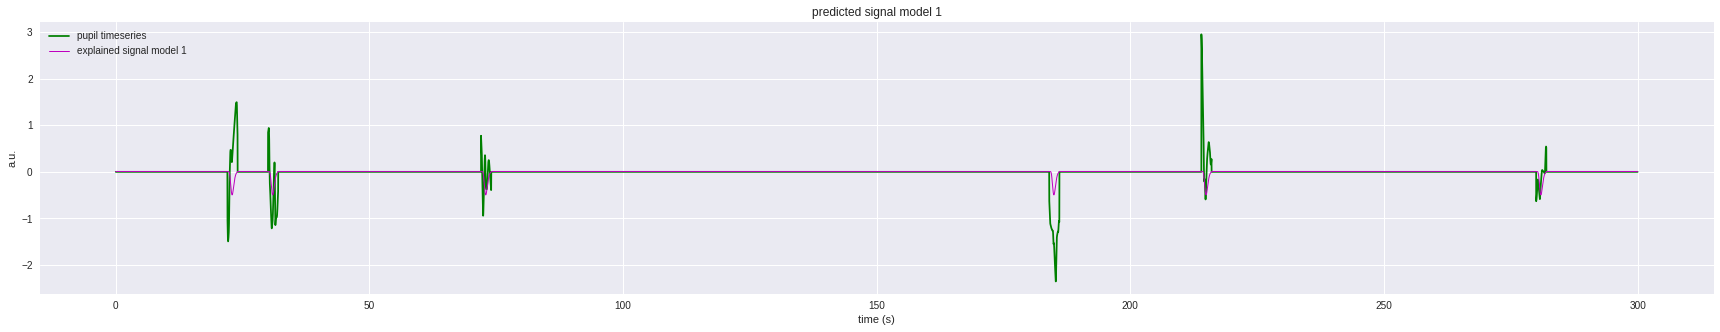

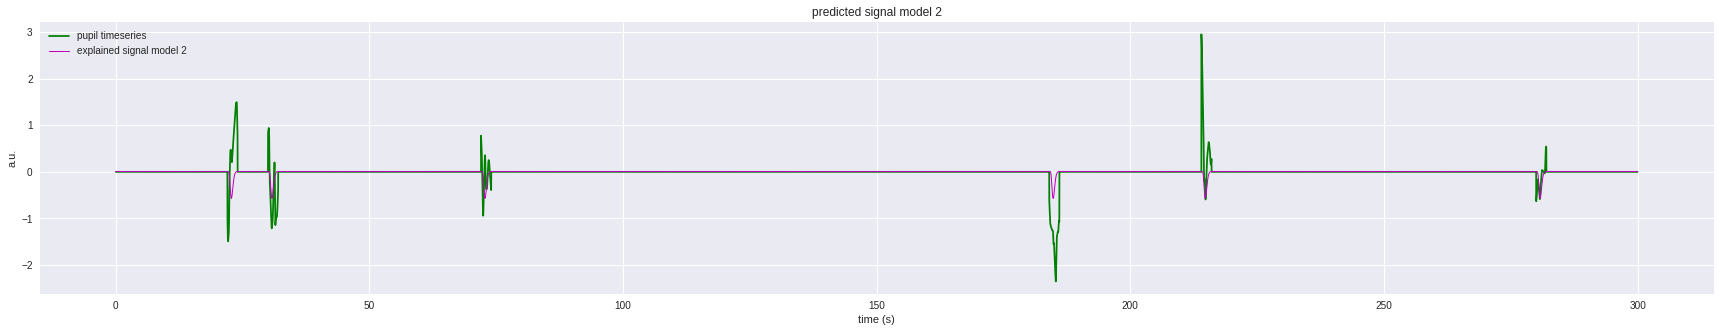

In [0]:
fig = plt.figure(figsize=(30, 5))
plt.plot(timepoints, input_signal_true, 'g')
# plt.plot(timepoints, convolved_signal, 'b')
# plt.ylim(-3,6)
plt.plot(timepoints, explained_signal_0, 'm', lw=1)
plt.legend(['pupil timeseries', 'explained signal model 1'], loc=2)
plt.title('predicted signal model 1')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

fig = plt.figure(figsize=(30, 5))
plt.plot(timepoints, input_signal_true, 'g')
# plt.plot(timepoints, convolved_signal, 'b')
plt.plot(timepoints, explained_signal_1, 'm', lw=1)
# plt.ylim(-3,6)
plt.legend(['pupil timeseries', 'explained signal model 2'], loc=2)
plt.title('predicted signal model 2')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

Text(0, 0.5, 'a.u.')

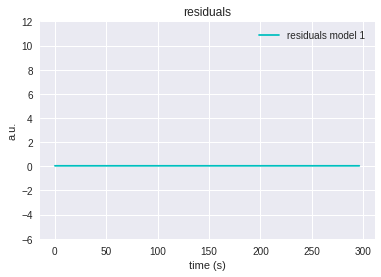

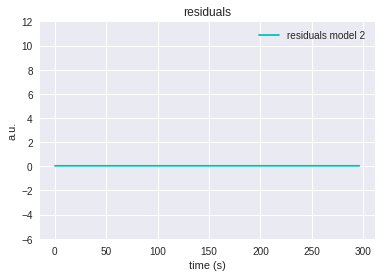

In [0]:
residuals_0 = convolved_signal_shifted - explained_signal_0
residuals_1 = convolved_signal_shifted - explained_signal_1

fig = plt.figure()
plt.plot(timepoints, residuals_0, 'c')
plt.ylim(-6,12)
plt.legend(['residuals model 1'], loc=1)
plt.title('residuals')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

fig = plt.figure()
plt.plot(timepoints, residuals_1, 'c')
plt.ylim(-6,12)
plt.legend(['residuals model 2'], loc=1)
plt.title('residuals')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

# **Test**

In [0]:
dir = "/gdrive/My Drive/PaulLab/video_study/"

from scipy.io import loadmat
# pupil_full_bic = loadmat(dir + 'Av_pupil_full_bic.mat')
# ges_time_bic = loadmat(dir + 'ges_time_bic.mat')

# content = pupil_full_bic['Av_pupil_full_bic']

In [0]:
pupil_time = content[0][0][0][0][0][0][:,0]
pupil_size = content[0][0][0][0][0][0][:,1]

start_time = ges_time_bic['ges_time_bic'][:,0]
end_time = ges_time_bic['ges_time_bic'][:,1]
duration = ges_time_bic['ges_time_bic'][:,2]

num = len(start_time)

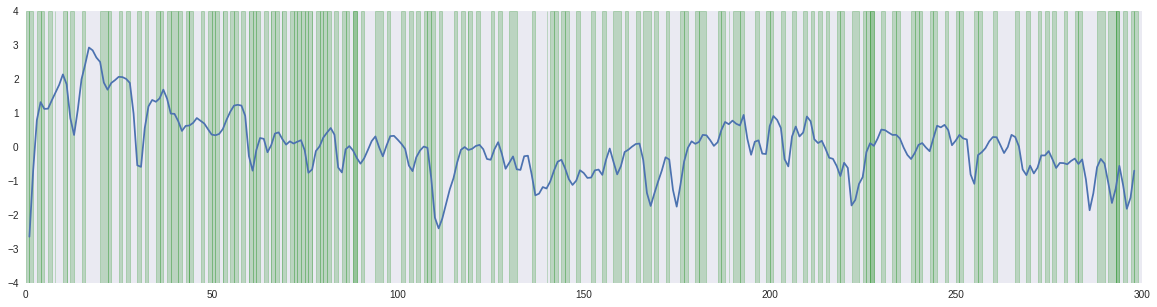

In [0]:
import matplotlib.patches as patches
# from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,figsize=(20, 5))
ax.plot(pupil_time, pupil_size)
ax.grid(False)
plt.xlim([0,300])
plt.ylim([-4,4])
for i in range(0,num):
    rect = patches.Rectangle((start_time[i],-4),duration[i],8,linewidth=1,
                             edgecolor='g',facecolor='g',alpha=0.2)
    ax.add_patch(rect)
plt.show()

In [0]:
import numpy as np

ind0 = np.where(duration==0)
ind0 = ind0[0]
ind1 = np.where(duration==1)
ind1 = ind1[0]
ind2 = np.where(duration==2)
ind2 = ind2[0]

In [0]:
print(ind2)

[ 10  19  60  76  86  89  95  99 112 139 140]


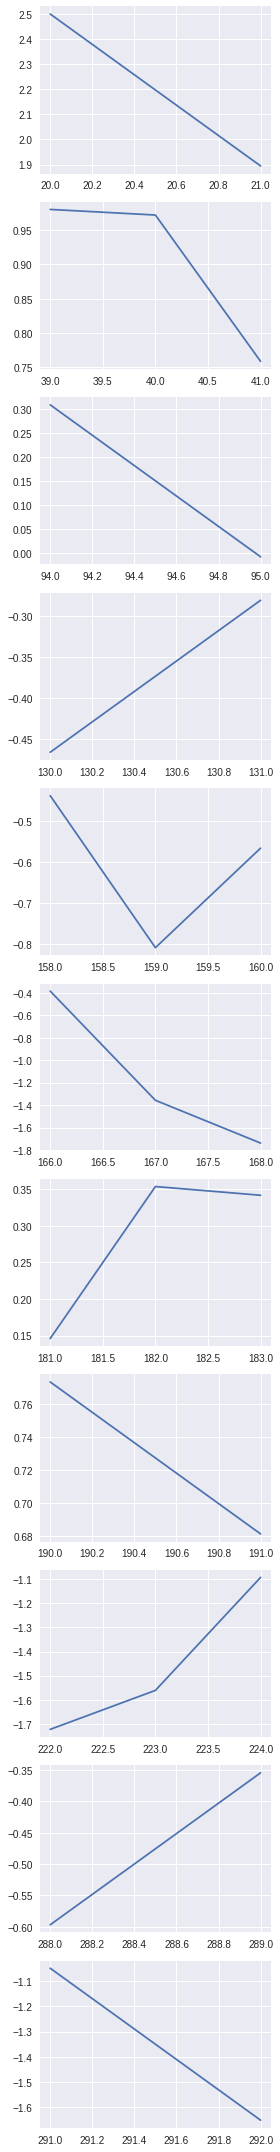

In [0]:
num_ind2 = len(ind2)

fig,ax = plt.subplots(num_ind2,1,figsize=(4, 30))
for i in range(0,num_ind2):
      t = ind2[i]
      s = start_time[t]
      e = end_time[t]
      ax[i].plot(range(s,e+1), pupil_size[s-1:e])
      
fig.tight_layout()
plt.show()

In [0]:
def IRF(t,t_max,w):
  h = np.power(t,w)*np.exp(-t*w/t_max)
  return h

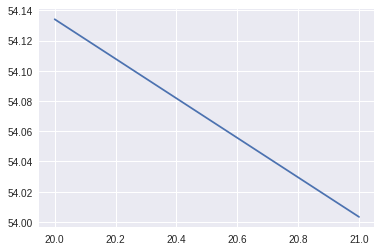

In [0]:
h = IRF(np.arange(start_time[10],end_time[10]+1), start_time[10], duration[10])

plt.plot(np.arange(start_time[10],end_time[10]+1),h)

In [0]:
x = np.arange(start_time[10]-1,end_time[10]+2,0.1)
print(x)

[19.  19.1 19.2 19.3 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1 20.2 20.3
 20.4 20.5 20.6 20.7 20.8 20.9 21.  21.1 21.2 21.3 21.4 21.5 21.6 21.7
 21.8 21.9 22.  22.1 22.2 22.3 22.4 22.5 22.6 22.7 22.8 22.9]


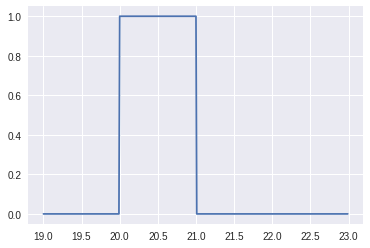

In [0]:
# plot a box
x = np.arange(start_time[10]-1,end_time[10]+2,0.01)
y = np.zeros(np.shape(x))
y[100:-199] = 1

plt.plot(x,y)

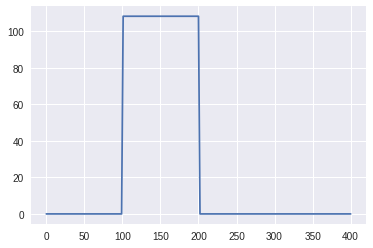

In [0]:
conv_h = np.convolve(y,h)

plt.plot(conv_h)

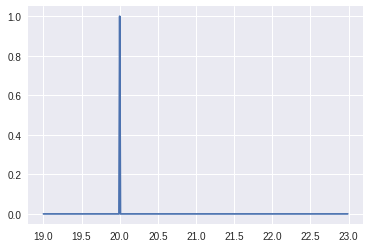

In [0]:
# plot a transient stimulus
x = np.arange(start_time[10]-1,end_time[10]+2,0.01)
y = np.zeros(np.shape(x))
y[100] = 1

plt.plot(x,y)

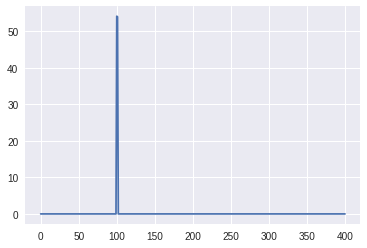

In [0]:
conv_h_start = np.convolve(y,h)

plt.plot(conv_h_start)

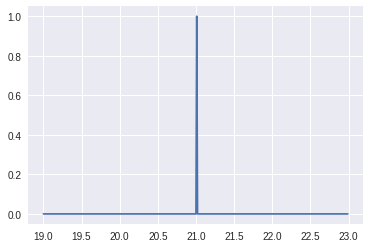

In [0]:
x = np.arange(start_time[10]-1,end_time[10]+2,0.01)
y = np.zeros(np.shape(x))
y[-199] = 1

plt.plot(x,y)

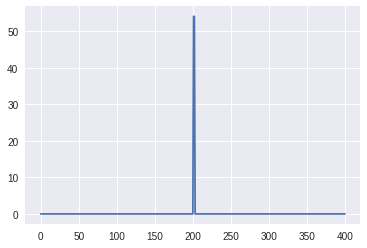

In [0]:
conv_h_end = np.convolve(y,h)

plt.plot(conv_h_end)

In [0]:
# GLM
